In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt 
import pickle 
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import ttest_ind,  shapiro, mannwhitneyu, pearsonr
import seaborn as sb

N_episode = 300
FIGSIZE = (16,9)
colors = ['crimson', 'royalblue', 'darkgreen', 'orange', 'blueviolet']
LW = 3

In [125]:
def plot_performance(data, X=None, names=None, title="", ylabel="performance", 
                     minimum = -np.inf, maximum=np.inf, log=False, double=False, xlabel="learning episodes"):
    """
    data = [n_param, n_run, episode_length]
    """
    
    if names is None:
        names = [str(j) for j in range(len(data))]
    compute_X = (X is None)
    if len(data)<6:
        ncol = [1,1,2,2,3][len(data)-1] 
    else:
        ncol = len(data)//2
    fig, ax = plt.subplots(figsize=FIGSIZE)
    handles = []
    for i in range(len(data)):
        if (double and i>=len(data)/2):
            linestyle = ":"
            color = colors[i%(len(data)//2)]
        else:
            linestyle = "-"
            color = colors[i%len(colors)]
        
        mean, std = np.mean(data[i], axis=0), np.std(data[i], axis=0)
        mean_p_std = np.minimum(mean+std, maximum)
        mean_m_std = np.maximum(mean-std, minimum)
        
        if compute_X:
            X = [x for x in range(len(mean))]

        for run in range(len(data[i])):
            plt.plot(X, data[i][run], color=color, lw=2, alpha=0.3)
        plt.plot(X,mean, color = color,lw=LW, linestyle=linestyle)
       # ax.fill_between(X,mean_p_std , mean_m_std, color= color, alpha=0.15)
       # plt.plot(X, mean_p_std, color=color, alpha=0.2)
        #plt.plot(X, mean_m_std, color=color, alpha=0.2)
        handles.append( mlines.Line2D([], [], color = color, linestyle=linestyle, label= names[i]))
    if log:
        plt.yscale("log")
        if (X[1]-X[0])!=(X[-1]-X[-2]):
            plt.xscale("log")
    else:
        if minimum != -np.inf and maximum!=np.inf:
            plt.ylim(minimum,maximum)
        elif minimum != -np.inf:
            plt.ylim(minimum)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(handles=handles, numpoints = 2,ncol=1,bbox_to_anchor=(1.01, 1.))
    plt.show()

In [65]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

def compute_test(data, coef=1, N=5):
    pairs = []
    for i in range(N-1):
        for j in range(i+1,N):
            pairs.append((i,j))
    res = [[] for _ in range(N)]
    cells = [[ '' for _ in range(N-1)] for _ in range(N-1)]
    for (param1,param2) in pairs:
        data1 = np.array(data[param1])
        data2 = np.array(data[param2])
        stat, p_t = ttest_ind(data1,data2)
        p_t = p_t*coef
        d = truncate( np.mean(data1)-np.mean(data2), 2)
        if d=='0.00' or d=='-0.00':
            d = truncate( np.mean(data1)-np.mean(data2), 3)
            if d=='0.000' or d=='-0.000':
                d = truncate( np.mean(data1)-np.mean(data2), 4)
        if p_t < 0.001:
            res.append((param1, param2, '***'))
            cells[param1][N-1-param2] = d+'\n***'
        elif p_t < 0.01:
            res.append((param1, param2, '**'))
            cells[param1][N-1-param2] = d+'\n**'
        elif p_t < 0.05:
            res.append((param1, param2, '*'))
            cells[param1][N-1-param2] = d+'\n*'
        else:
            cells[param1][N-1-param2] = "ns"
    return res,cells

def plot_boxplot(data, names, ylabel="performance", ylim=None, title=""):
    N = len(data)
    stat,cells = compute_test(data, 3*N*(N-1)/2, N)
    
    plt.subplots(figsize=(12,10))
    
    bplot = sb.boxplot(data=data)
    for i in range(N):
        bplot.artists[i].set_facecolor(colors[i])
    sb.swarmplot( data=data, color='black', edgecolor='black',size=7)
    
    rows = names[:N-1]
    columns = [names[i] for i in range(N-1,0,-1)]
    cell_text = cells
    cellColours = [['white' if N-1-i>j else 'lightgrey' for j in range(N-1)] for i in range(N-1) ]
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          cellColours= cellColours,
                          rowColours=colors[:N-1],
                          colColours=[ colors[i] for i in range(N-1,0,-1)],
                          colLabels=columns,
                          cellLoc = 'center',
                          bbox=(1.13,0.1,0.5,0.9))
    
    plt.xticks(range(N), names)
    if not ylim is None:
        plt.ylim(ylim)
    plt.ylabel(ylabel)
    plt.title(title)

In [66]:
def plot_z_rewards(subdirs, names, episodes=100):
    Rewards = []
    for param in subdirs:
        rewards = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            obs = data['observations'][:N_episode]
            rewards.append(obs[:, -1, 30] < 0.13)
            if min_length > len(obs):
                min_length = len(obs)
        rewards = np.sum([reward[min_length-episodes:min_length]/(episodes) for reward in rewards], axis=1)
        Rewards.append(list(rewards))
    title="Average Percentage of fall of the last "+ str(episodes)+ " episodes"
    plot_boxplot(Rewards, names, ylim=[0,1], ylabel="Percentage of fall", title=title)
    
def plot_x_rewards(subdirs, names, episodes=100, z=False):
    Rewards = []
    for param in subdirs:
        rewards = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            obs = data['observations'][:N_episode]
            rewards.append(obs[:, -1, 28] * (obs[:, -1, 30] > 0.13 )**z)
            if min_length > len(obs):
                min_length = len(obs)
        rewards = np.mean([reward[min_length-episodes:min_length] for reward in rewards], axis=1)
        Rewards.append(list(rewards))
    title = "Farther point reached"+ " on legs"*z+ " on the last "+ str(episodes)+ " episodes"
    plot_boxplot(Rewards, names, ylim=[0,5], ylabel="Average distance reached", 
                 title=title)
    
def plot_last_x_rewards(subdirs, names, episodes=100):
    Rewards = []
    for param in subdirs:
        rewards = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            obs = data['observations'][:N_episode]
            if min_length > len(obs):
                min_length = len(obs)
        for folder in param:
            data = scipy.io.loadmat(folder)
            obs = data['observations'][min_length-episodes:min_length]
            on_legs = obs[:, :, 30] > 0.13
            reward = []
            for i in range(len(on_legs)):
                j = 0
                while (j < len(obs[i])-1) and on_legs[i,j]:
                    j+=1
                reward.append(obs[i,j,28])
            rewards.append(np.mean(reward))
        Rewards.append(list(rewards))
    title = "Farther point reached on legs on the last "+ str(episodes)+ " episodes"
    plot_boxplot(Rewards, names, ylim=[0,5], ylabel="Average distance reached", title=title)

In [112]:
def plot_rewards(subdirs, names):
    Rewards = []
    for param in subdirs:
        rewards = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            reward = data['reward_sum'][0][:N_episode]
            rewards.append(reward)
            if min_length > len(reward):
                min_length = len(reward)
        rewards = [ reward[:min_length] for reward in rewards]
        Rewards.append(np.copy(rewards))
    plot_performance(Rewards, names=names)
    
def plot_x_rewards_along(subdirs, names):
    Rewards = []
    for param in subdirs:
        rewards = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            obs = data['observations'][:N_episode]
            rewards.append(obs[:, -1, 28])
            if min_length > len(obs):
                min_length = len(obs)
        rewards = [ reward[:min_length] for reward in rewards]
        Rewards.append(np.copy(rewards))
    plot_performance(Rewards, names=names)
    
    
def plot_mean_observations(subdirs, names, p):
    Data = []
    for param in subdirs:
        obs = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)def plot_model_eval(subdirs, names):
    Rewards = []
    for param in subdirs:
        rewards = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            obs = data['model_eval']
            rewards.append(obs)
            if min_length > len(obs):
                min_length = len(obs)
        rewards = [ reward[:min_length] for reward in rewards]
        Rewards.append(np.copy(rewards))
    plot_performance(Rewards, names=names)
            data = data['observations']
            obs.append(np.mean(data[:, :, p], axis=1))
            if min_length > len(data):
                min_length = len(data)
        obs = [ data[100:min_length] for data in obs]
        Data.append(obs)
    plot_performance(Data, names=names)

def plot_actions(subdirs, names):
    Actions = []
    for param in subdirs:
        actions = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            action = data['actions'][:N_episode]
            actions.append(np.mean(np.linalg.norm(action, axis=2), axis=1))
            if min_length > len(action):
                min_length = len(action)
        actions = [ action[:min_length] for action in actions]
        Actions.append(np.copy(actions))
    plot_performance(Actions, names=names)

In [104]:
path = "./exp/log/Saved/Minitaur/"
basic = ['2019-09-19--16:28:4567868', '2019-09-19--16:28:4578924', '2019-09-19--16:36:4580494', 
         '2019-09-19--16:36:4881412', '2019-09-19--16:36:5449261']

survival_1 = ['2019-09-19--16:52:5532215', '2019-09-19--16:52:5551504', '2019-09-19--16:52:5570275', 
            '2019-09-19--16:52:5581499', '2019-09-19--16:52:5597921']

H5 = ['2019-09-24--10:21:5191869', '2019-09-24--10:21:5110873', '2019-09-24--10:21:5163646', 
     '2019-09-24--10:21:5196508', '2019-09-24--10:21:5181973', '2019-09-24--10:21:5137822']

H10 = ['2019-09-23--11:24:201720', '2019-09-23--11:24:2096429', '2019-09-23--11:24:2074800']

H15 = ['2019-09-25--09:54:2075310', '2019-09-25--09:54:2060523', '2019-09-25--09:54:2051457']

H20 = ['2019-09-24--10:21:5156740', '2019-09-24--10:21:5157288', '2019-09-24--10:25:2999920']

H30 = ['2019-09-23--11:24:2046092', '2019-09-23--11:24:2012280', '2019-09-23--11:24:207185']

energy_0005 = ['2019-09-23--11:58:2197705', '2019-09-23--11:58:2156618', '2019-09-23--11:58:2181550']

energy_0001 = ['2019-09-24--10:25:5375726', '2019-09-24--10:25:5472040', '2019-09-24--10:25:5348002']

survival_01 = ['2019-09-23--11:24:2095463', '2019-09-23--11:24:2099924', '2019-09-23--11:58:215657']

All = ['2019-09-24--10:25:535604', '2019-09-24--10:26:1720332', '2019-09-24--10:26:1733629']


H5_survival_10 = ['2019-09-25--09:54:208188', '2019-09-25--09:54:2065241', '2019-09-25--09:54:2061487']

H10_survival_10 = ['2019-09-25--09:54:2041199', '2019-09-25--09:54:2024283', '2019-09-25--09:58:0658851']

H15_survival_10 = ['2019-09-25--09:58:0689093', '2019-09-25--09:58:0636850', '2019-09-25--09:58:0665189']

H20_survival_10 = ['2019-09-24--10:25:2963472', '2019-09-24--10:25:2914893', '2019-09-24--10:25:296303']

H30_survival_10 = ['2019-09-25--09:58:303678', '2019-09-25--09:58:3166739', '2019-09-25--09:58:3037869']

MVL100 = ['2019-09-25--16:26:3944586', '2019-09-25--17:00:316060', '2019-09-25--17:01:5611535']

MVL125 = ['2019-09-26--16:02:3624810', '2019-09-26--16:02:3665513', '2019-09-26--16:02:3618254']

MVL150 = ['2019-09-25--17:22:3848942', '2019-09-25--17:53:3026893', '2019-09-25--17:53:3030845']

MVL175 = ['2019-09-26--16:02:3625416', '2019-09-26--16:02:2537891', '2019-09-26--16:02:2568']

MVL200 = ['2019-09-25--17:53:3054177', '2019-09-25--17:53:308758', '2019-09-25--18:38:2652190']

MVL300 = ['2019-09-25--18:48:0943648', '2019-09-25--20:19:0345732', '2019-09-25--20:19:0345732']

MVL150_H10 = ['2019-09-26--16:02:369379', '2019-09-26--16:02:3631359', '2019-09-26--16:02:3639260']

MVL150_H30 = ['2019-09-26--16:02:3678965', '2019-09-26--16:02:3699712', '2019-09-26--16:02:3657644']

angle_033 = ['2019-09-26--16:57:574167', '2019-09-26--16:57:5792342', '2019-09-26--16:57:5745316']

angle_05 = ['2019-09-26--16:57:5720990', '2019-09-26--16:57:5793716', '2019-09-26--16:57:5776328']

K5 = ['2019-09-26--16:45:2856141', '2019-09-26--16:57:4587438', '2019-09-26--16:57:4523389']

K10 = ['2019-09-26--16:57:4540348', '2019-09-26--16:57:457902', '2019-09-26--16:57:5773657']

K20 = ['2019-09-26--16:57:5767862', '2019-09-26--16:57:5723746', '2019-09-26--16:57:5760663']

# 30/09/19
al_05_h10 = ['2019-09-27--10:42:5392306', '2019-09-27--10:42:5366417', '2019-09-27--10:42:5356616']

al_05_h15 = ['2019-09-27--10:42:5333994', '2019-09-27--10:42:5381499', '2019-09-27--10:42:5328836']

al_05_h30 = ['2019-09-27--10:42:5373080', '2019-09-27--10:42:5315175', '2019-09-27--10:42:535159']

LS100 = ['2019-09-27--16:38:1881257', '2019-09-27--16:38:1842629', '2019-09-27--16:38:1876740']

LS400 = ['2019-09-27--16:38:1871614', '2019-09-27--16:38:171540', '2019-09-27--16:38:3193512']

LS800 = ['2019-09-27--16:38:2992142', '2019-09-27--16:38:2942663', '2019-09-27--16:38:3158102']

#01/10/19
popsize_1k = ['2019-09-30--16:40:582204', '2019-09-30--16:40:5849131', '2019-09-30--16:40:5881857']

popsize_4k = ['2019-09-30--16:39:1657648', '2019-09-30--16:39:168852', '2019-09-30--16:40:1830141']

popsize_8k = ['2019-09-30--16:39:166424', '2019-09-30--16:39:1693231', '2019-09-30--16:39:1653839']

popsize_16k = ['2019-09-30--16:39:1612337', '2019-09-30--16:39:1626973', '2019-09-30--16:39:1612758']

test = [['./exp/log/Saved/2019-10-02--11:26:046210/logs.mat']]

subdirs1 = [
            [path + x + '/logs.mat' for x in H10], 
            [path + x + '/logs.mat' for x in H10_survival_10],
            [path + x + '/logs.mat' for x in H30],
            [path + x + '/logs.mat' for x in H30_survival_10],
]


subdirs2 = [
            [path + x + '/logs.mat' for x in H5], 
            [path + x + '/logs.mat' for x in H10], 
            [path + x + '/logs.mat' for x in H15],
            [path + x + '/logs.mat' for x in H20],
            [path + x + '/logs.mat' for x in H30],
]

subdirs3 = [
            [path + x + '/logs.mat' for x in H5_survival_10], 
            [path + x + '/logs.mat' for x in H10_survival_10], 
            [path + x + '/logs.mat' for x in H15_survival_10],
            [path + x + '/logs.mat' for x in H20_survival_10],
            [path + x + '/logs.mat' for x in H30_survival_10],
]

subdirs4 = [
            [path + x + '/logs.mat' for x in MVL100], 
            [path + x + '/logs.mat' for x in MVL125],
            [path + x + '/logs.mat' for x in MVL150],
            [path + x + '/logs.mat' for x in MVL175],
            [path + x + '/logs.mat' for x in MVL200],
]

subdirs5 = [
            [path + x + '/logs.mat' for x in MVL150_H10],
            [path + x + '/logs.mat' for x in MVL150], 
            [path + x + '/logs.mat' for x in MVL150_H30],
]

subdirs6 = [
            [path + x + '/logs.mat' for x in angle_05],
            [path + x + '/logs.mat' for x in angle_033],
]

subdirs7 = [
            [path + x + '/logs.mat' for x in MVL150], 
            [path + x + '/logs.mat' for x in K5], 
            [path + x + '/logs.mat' for x in K10],
            [path + x + '/logs.mat' for x in K20],
]

subdirs8 = [
            [path + x + '/logs.mat' for x in al_05_h10],
            [path + x + '/logs.mat' for x in al_05_h15], 
            [path + x + '/logs.mat' for x in angle_05], 
            [path + x + '/logs.mat' for x in al_05_h30],
]

subdirs9 = [
            [path + x + '/logs.mat' for x in LS100],
            [path + x + '/logs.mat' for x in LS800],
]

subdirs10 = [
            [path + x + '/logs.mat' for x in popsize_1k],
            [path + x + '/logs.mat' for x in popsize_4k],
            [path + x + '/logs.mat' for x in popsize_8k],
            [path + x + '/logs.mat' for x in popsize_16k],
]

names1 = ['10', '10 + s', '30', '30 + s']
names3 = names2 = ['5', "10", "15", "20", "30"]
names4 = ['100', '125', '150', '175', '200']
names5 = ['H10', 'H20', 'H30']
names6 = ['no limit', '50%', '33%']
names7 = ['1', '5', '10', '20']
names8 = ['10', '15', '20', '30']
names9 = ['100', '800']
names10 = ['1k', '4k', '8k', '16k']

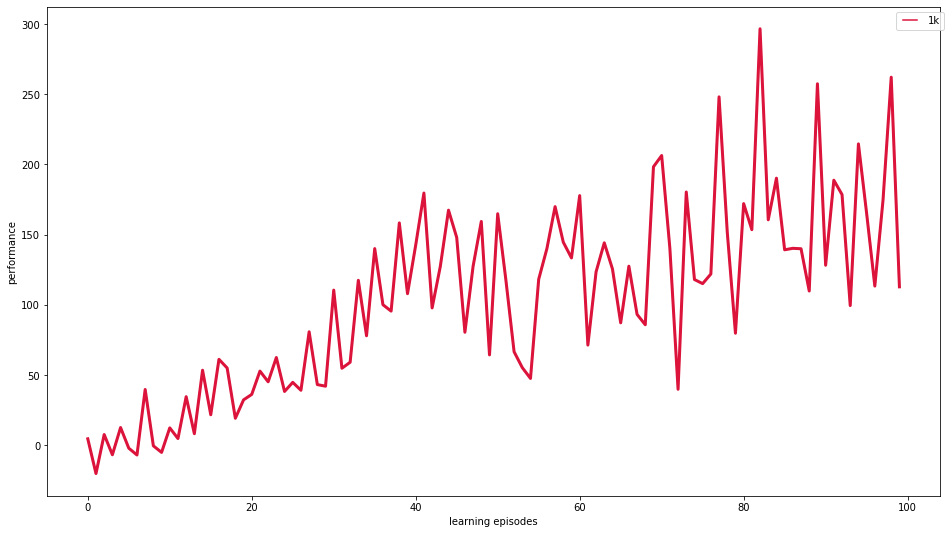

In [105]:
plot_rewards(test, names10)

In [127]:
def plot_model_eval(subdirs, names):
    Rewards = []
    for param in subdirs:
        rewards = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            obs = data['model_eval']
            rewards.append(obs)
            if min_length > len(obs):
                min_length = len(obs)
        rewards = [ reward[:min_length] for reward in rewards]
        Rewards = np.copy(rewards)
    plot_performance(Rewards, names=names)

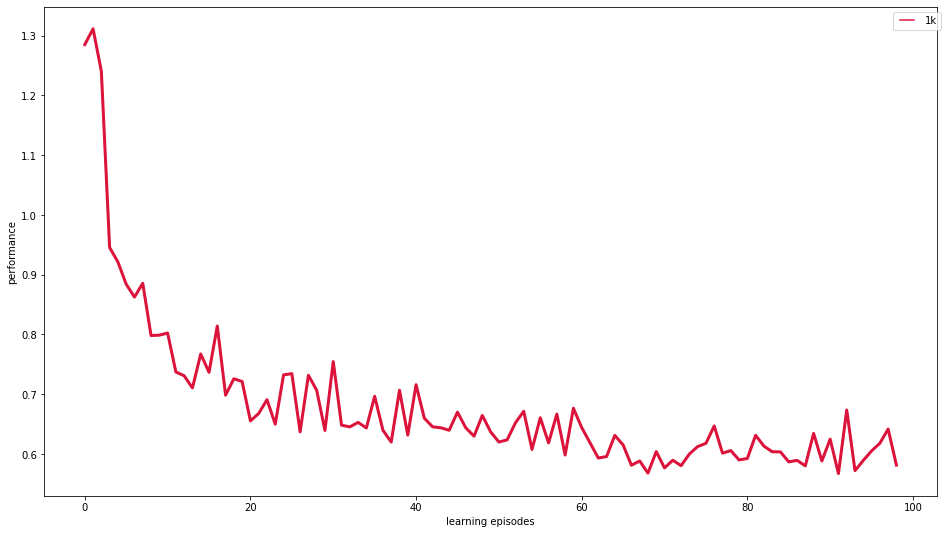

In [128]:
plot_model_eval(test, names10)

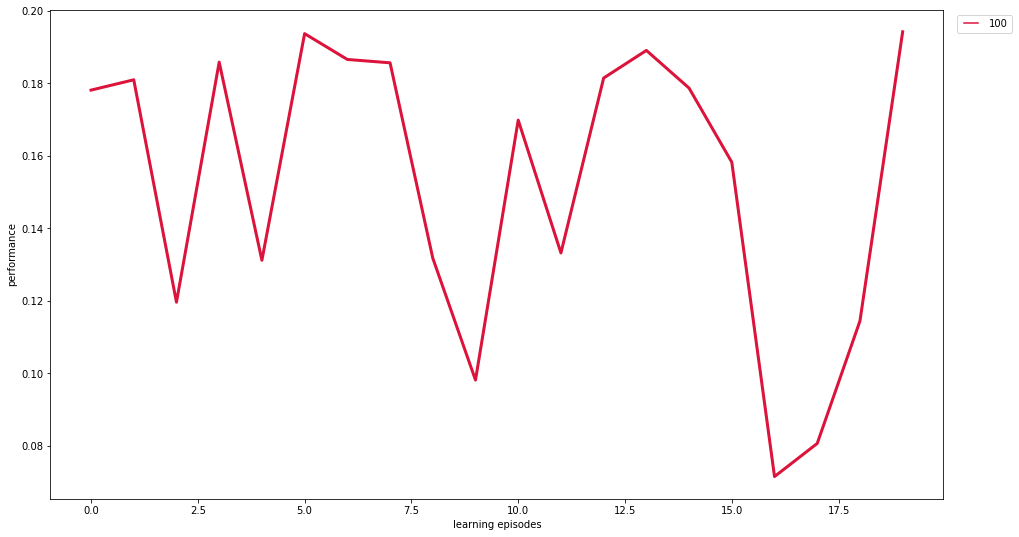

In [87]:
plot_mean_observations(test, names4, 30)

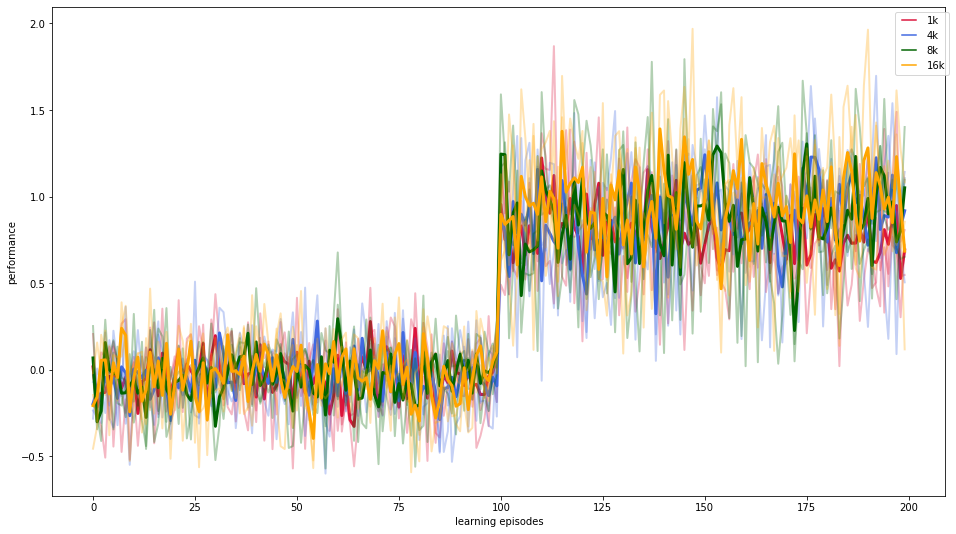

In [72]:
plot_x_rewards_along(subdirs10, names10)

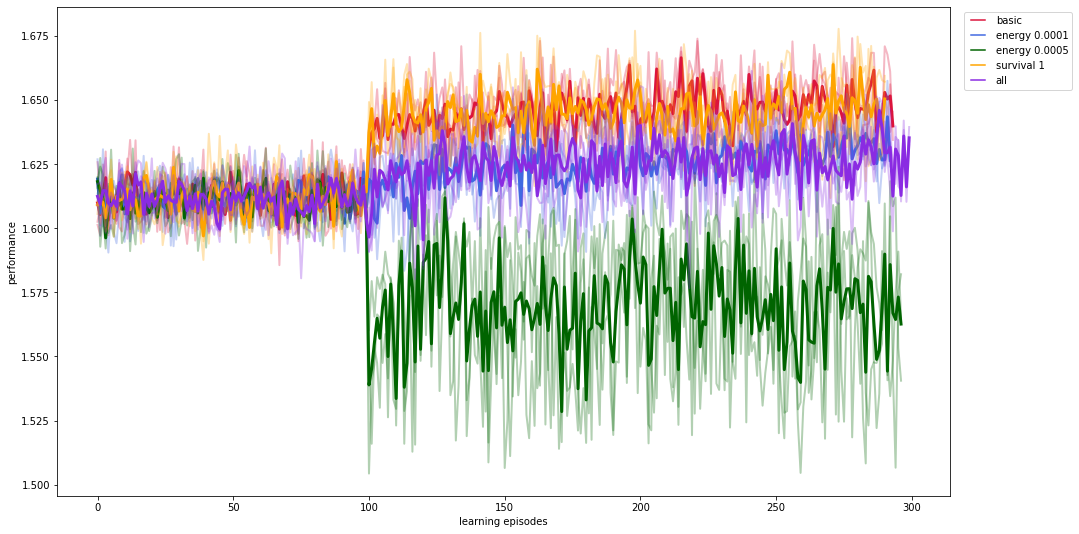

In [392]:
plot_actions(subdirs1, names1)

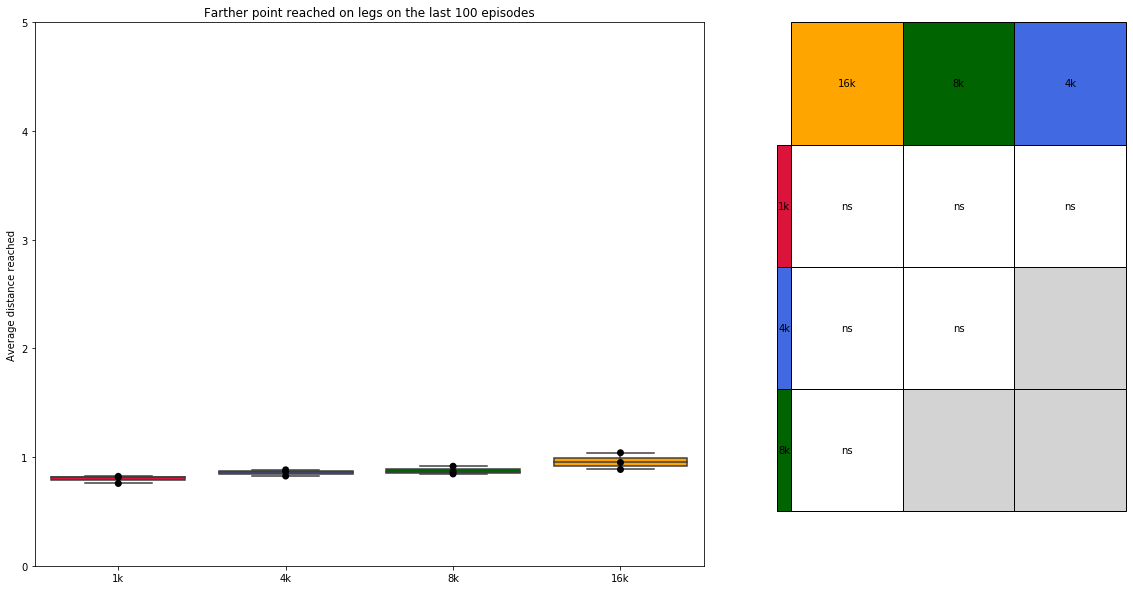

In [60]:
plot_last_x_rewards(subdirs10, names10, 100)

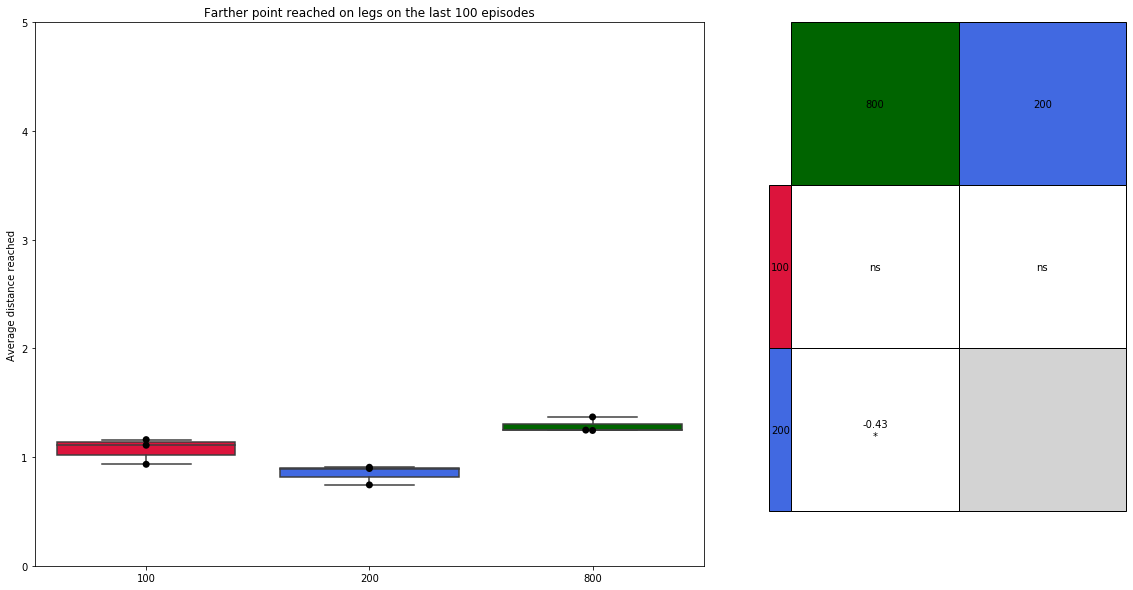

In [30]:
plot_x_rewards(subdirs9, names9, 100, 1)

/home/timothee/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/timothee/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


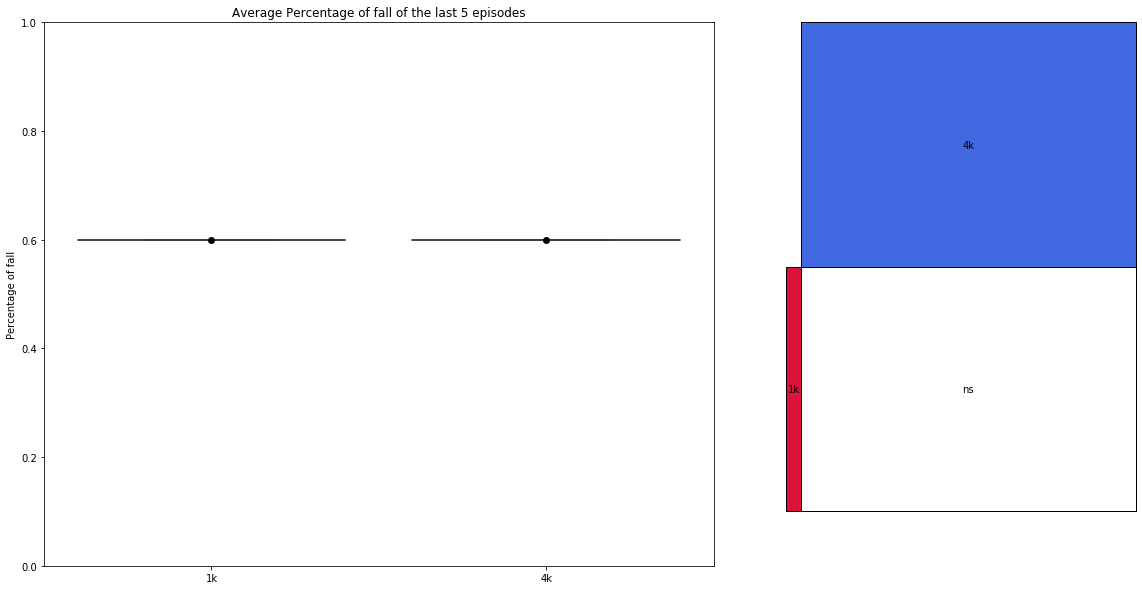

In [80]:
plot_z_rewards([test[0],test[0]], names10, 5)

In [56]:
def plot_error(subdirs, names):
    Errors = []
    for param in subdirs:
        errors = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            error = data['model_error'][0]
            errors.append(error)
            if min_length > len(error):
                min_length = len(error)
        errors = [ error[:min_length] for error in errors]
        Errors.append(np.copy(errors))
    plot_performance(Errors, names=names)
    

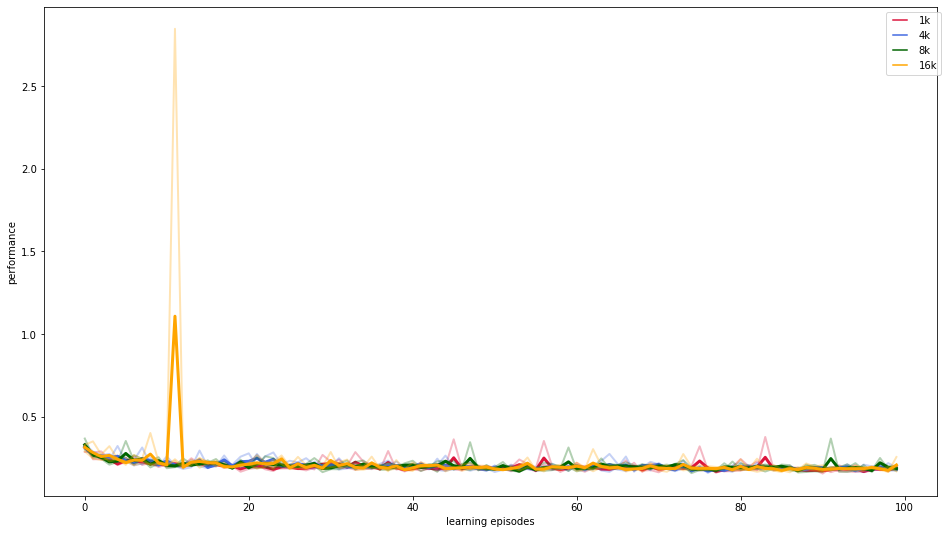

In [70]:
plot_error(subdirs10, names10)

In [246]:
from time import time

In [248]:
def preprocess_data(traj_obs, traj_acs):
    N = len(traj_acs)
    horizon = 25
    episode_length = 250
    actions, init_observations, observations = [], [], []
    for i in range(N):
        for t in range(0, len(traj_acs), horizon):
            actions.append(traj_acs[i][t:t + horizon].flatten())
            init_observations.append(traj_obs[i][t])
            observations.append(traj_obs[i][t + 1:t + 1 + horizon].flatten())
    return np.array(actions), np.array(init_observations), np.array(observations)

In [249]:
traj_obs = np.random.random((N, 251, 31))
traj_acs = np.random.random((N, 250, 8))

In [251]:
t0 = time()
a, i, o = preprocess_data(traj_obs, traj_acs)
print(time()-t0)
t0 = time()

print(time()-t0)

0.047322988510131836


In [256]:
test = np.array([[0,1,2,3,4,5,6,7,8,9],[10,11,12,13,14,15,16,17,18],[20,21,22,23,24,25,26,27,28,29]])


0
3
